In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations
sns.set_theme("notebook")

In [2]:
patients = pd.read_csv("experiment_data/prostate_tumours_patients.csv")
tumours = pd.read_csv("experiment_data/prostate_tumours.csv", low_memory=False)

In [3]:
print(patients.columns)
print(tumours.columns)

Index(['PATIENTID', 'GENDER', 'ETHNICITY', 'DEATHCAUSECODE_1A',
       'DEATHCAUSECODE_1B', 'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2',
       'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'VITALSTATUS',
       'VITALSTATUSDATE', 'LINKNUMBER'],
      dtype='object')
Index(['TUMOURID', 'GENDER', 'PATIENTID', 'DIAGNOSISDATEBEST',
       'SITE_ICD10_O2_3CHAR', 'SITE_ICD10_O2',
       'SITE_ICD10R4_O2_3CHAR_FROM2013', 'SITE_ICD10R4_O2_FROM2013',
       'SITE_ICDO3REV2011', 'SITE_ICDO3REV2011_3CHAR', 'MORPH_ICD10_O2',
       'MORPH_ICDO3REV2011', 'BEHAVIOUR_ICD10_O2', 'BEHAVIOUR_ICDO3REV2011',
       'T_BEST', 'N_BEST', 'M_BEST', 'STAGE_BEST', 'GRADE', 'AGE', 'CREG_CODE',
       'STAGE_BEST_SYSTEM', 'LATERALITY', 'SCREENINGSTATUSFULL_CODE',
       'ER_STATUS', 'PR_STATUS', 'HER2_STATUS', 'QUINTILE_2019',
       'DATE_FIRST_SURGERY', 'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS',
       'CHRL_TOT_27_03', 'COMORBIDITIES_27_03', 'GLEASON_PRIMARY',
       'GLEASON_SECONDARY', 'GLEASON_TERTIARY',

In [4]:
ethnicities = pd.read_excel("../../data/simulacrum_v2.1.0/Documents/all_z_lookup_tables.xlsx", sheet_name='z_ethnicity')

ethnicities

,Code,Description
0,0,White
1,8,Other
2,A,White British
3,B,White Irish
4,C,Any other White background
5,CA,English
6,CH,Turkish
7,CP,Polish
8,D,White and Black Caribbean
9,E,White and Black African


In [5]:
ethnicity_mapper = {
    '0': 'White',
    '8': 'Other',
    'A': 'White British',
    'B': 'White Irish',
    'C': 'Any other White background',
    'CA': 'English',
    'CH': 'Turkish',
    'CP': 'Polish',
    'D': 'White and Black Caribbean',
    'E': 'White and Black African',
    'F': 'White and Asian',
    'G': 'Any other mixed background',
    'H': 'Asian Indian',
    'J': 'Asian Pakistani',
    'K': 'Asian Bangladeshi',
    'L': 'Any other Asian background',
    'M': 'Black Caribbean',
    'N': 'Black African',
    'P': 'Any other Black background',
    'R': 'Chinese',
    'S': 'Any other ethnic group',
    'X': 'Not known',
    'Z': 'Not specified' 
}

## 1. Distribution of Ethnicities

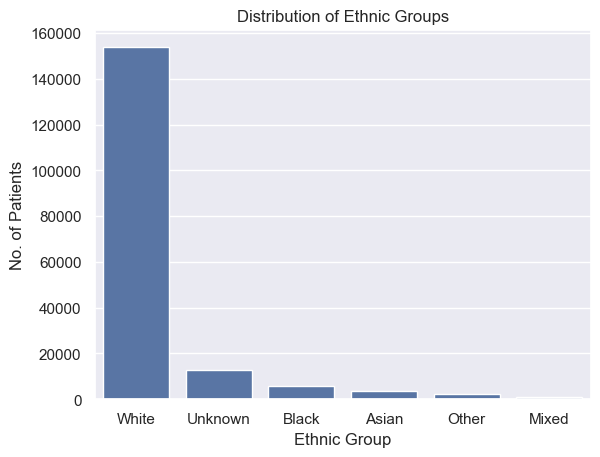

In [6]:
# shrink the ethnicities
def categorize_ethnicity(ethnicity):
    if ethnicity in ['White', 'White British', 'White Irish', 'Any other White background', 'English', 'Polish']:
        return 'White'
    elif ethnicity in ['Asian Indian', 'Asian Pakistani', 'Asian Bangladeshi', 'Any other Asian background', 'Chinese']:
        return 'Asian'
    elif ethnicity in ['Black Caribbean', 'Black African', 'Any other Black background']:
        return 'Black'
    elif ethnicity in ['White and Black Caribbean', 'White and Black African', 'White and Asian', 'Any other mixed background']:
        return 'Mixed'    
    elif ethnicity in ['Turkish']:
        return 'Turkish'
    elif ethnicity in ['Any other ethnic group']:
        return 'Other'
    else:
        return 'Unknown'

# Map the ethnicity codes to their descriptions
patients['ETHNICITY_DESC'] = patients['ETHNICITY'].map(ethnicity_mapper)
patients['ETHNIC_GROUP'] = patients['ETHNICITY_DESC'].apply(categorize_ethnicity)
plt.figure()
sns.barplot(patients['ETHNIC_GROUP'].value_counts())
plt.title("Distribution of Ethnic Groups")
plt.xlabel("Ethnic Group")
plt.ylabel("No. of Patients")
plt.show()

In [7]:
combined_data = patients.merge(tumours, on='PATIENTID', how='inner')
print(patients.shape)
print(tumours.shape)
print(combined_data.shape)

(179322, 14)
(179478, 37)
(179478, 50)


In [8]:
combined_data = combined_data[combined_data['ETHNIC_GROUP']!='Unknown']
combined_data.columns

Index(['PATIENTID', 'GENDER_x', 'ETHNICITY', 'DEATHCAUSECODE_1A',
       'DEATHCAUSECODE_1B', 'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2',
       'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'VITALSTATUS',
       'VITALSTATUSDATE', 'LINKNUMBER', 'ETHNICITY_DESC', 'ETHNIC_GROUP',
       'TUMOURID', 'GENDER_y', 'DIAGNOSISDATEBEST', 'SITE_ICD10_O2_3CHAR',
       'SITE_ICD10_O2', 'SITE_ICD10R4_O2_3CHAR_FROM2013',
       'SITE_ICD10R4_O2_FROM2013', 'SITE_ICDO3REV2011',
       'SITE_ICDO3REV2011_3CHAR', 'MORPH_ICD10_O2', 'MORPH_ICDO3REV2011',
       'BEHAVIOUR_ICD10_O2', 'BEHAVIOUR_ICDO3REV2011', 'T_BEST', 'N_BEST',
       'M_BEST', 'STAGE_BEST', 'GRADE', 'AGE', 'CREG_CODE',
       'STAGE_BEST_SYSTEM', 'LATERALITY', 'SCREENINGSTATUSFULL_CODE',
       'ER_STATUS', 'PR_STATUS', 'HER2_STATUS', 'QUINTILE_2019',
       'DATE_FIRST_SURGERY', 'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS',
       'CHRL_TOT_27_03', 'COMORBIDITIES_27_03', 'GLEASON_PRIMARY',
       'GLEASON_SECONDARY', 'GLEASON_TERTIARY

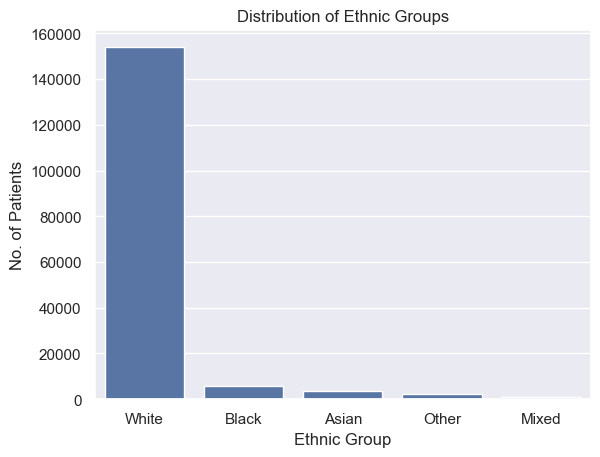

In [9]:
analysis_cols = ['ETHNIC_GROUP', 'AGE', 'GLEASON_PRIMARY', 'GLEASON_SECONDARY', 'GLEASON_TERTIARY', 'GLEASON_COMBINED', 'GRADE', 'STAGE_BEST', 'T_BEST', 'M_BEST', 'N_BEST']
analysis_data = combined_data[analysis_cols]

plt.figure()
sns.barplot(analysis_data['ETHNIC_GROUP'].value_counts())
plt.title("Distribution of Ethnic Groups")
plt.xlabel("Ethnic Group")
plt.ylabel("No. of Patients")
plt.show()

## 2. Is there a notable variation for age at dianosis across ethnicities?

In [10]:
analysis_data.groupby('ETHNIC_GROUP')['AGE'].agg(['count', 'mean', 'std', 'median', 'min', 'max'])

,count,mean,std,median,min,max
ETHNIC_GROUP,,,,,,
Asian,3708,70.495955,9.724960,71.0,0,102
Black,5858,70.970468,9.651958,71.0,21,102
Mixed,891,70.228956,9.231437,71.0,37,95
Other,2110,70.779147,9.645128,71.0,26,100
White,153940,70.744342,9.678478,71.0,0,104


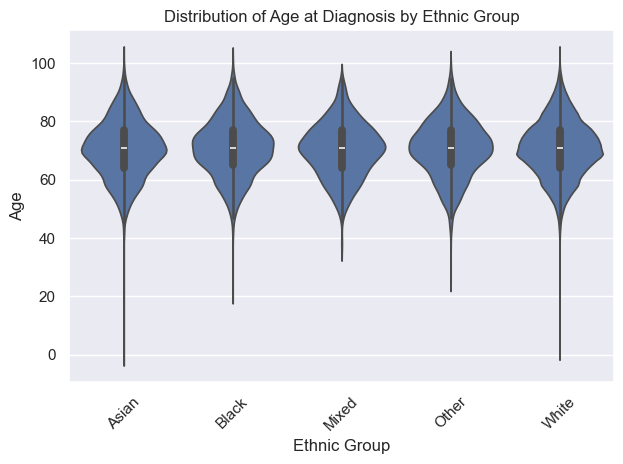

In [11]:
sns.violinplot(x='ETHNIC_GROUP', y='AGE', data=analysis_data,
               order=['Asian', 'Black', 'Mixed', 'Other', 'White'], inner='box')
plt.title('Distribution of Age at Diagnosis by Ethnic Group')
plt.ylabel('Age')
plt.xlabel('Ethnic Group')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('age_by_ethnicity_violin.png')
plt.show()

In [12]:
# ANOVA test for significant differences across ages
model = ols('AGE ~ C(ETHNIC_GROUP)', data=analysis_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(ETHNIC_GROUP),7.675297e+02,4.0,2.049552,0.084587
Residual,1.558819e+07,166502.0,NaN,NaN


In [13]:
# post-hoc tests
posthoc = pairwise_tukeyhsd( analysis_data['AGE'], analysis_data['ETHNIC_GROUP'],alpha=0.05)

print(posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 Asian  Black   0.4745 0.1333 -0.0794 1.0284  False
 Asian  Mixed   -0.267 0.9472 -1.2517 0.7177  False
 Asian  Other   0.2832 0.8203 -0.4365 1.0029  False
 Asian  White   0.2484 0.5332 -0.1902  0.687  False
 Black  Mixed  -0.7415 0.2068 -1.6906 0.2076  False
 Black  Other  -0.1913 0.9368 -0.8614 0.4788  False
 Black  White  -0.2261 0.3998 -0.5775 0.1252  False
 Mixed  Other   0.5502 0.6126 -0.5043 1.6047  False
 Mixed  White   0.5154 0.5068 -0.3714 1.4022  False
 Other  White  -0.0348 0.9998 -0.6133 0.5437  False
---------------------------------------------------


Statistically, there is no evidence that ethnicity affects the age at diagnosis, though it's close (0.08).

Therefore, we cannot infer that men from a particular ethnic group are diagnosed at an earlier or later age.


## 3. How does the Gleason score at Diagnostic interact with ethnicity?

In [14]:
analysis_data[analysis_data['GLEASON_COMBINED'].isnull()]

,ETHNIC_GROUP,AGE,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,GRADE,STAGE_BEST,T_BEST,M_BEST,N_BEST
10,White,72,NaN,NaN,NaN,NaN,GX,?,NaN,NaN,NaN
18,White,57,NaN,NaN,NaN,NaN,GX,4,3b,0,1
22,White,63,NaN,NaN,NaN,NaN,GX,4,NaN,1b,NaN
29,White,68,NaN,NaN,NaN,NaN,GX,3,3,0,0
37,White,62,NaN,NaN,NaN,NaN,G,4,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
179470,White,56,NaN,NaN,NaN,NaN,GX,1,NaN,0,0
179471,White,50,NaN,NaN,NaN,NaN,G2,4,1,0,1
179473,White,44,NaN,NaN,NaN,NaN,GX,U,NaN,1,0
179474,White,73,NaN,NaN,NaN,NaN,GX,2,NaN,0,0


/var/folders/y9/3sbrg0zd1fnd2xl6hzd2trlm0000gq/T/ipykernel_2162/3166075548.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['GLEASON_SEVERITY'] = np.select(conditions, choices)


<Figure size 1400x800 with 0 Axes>

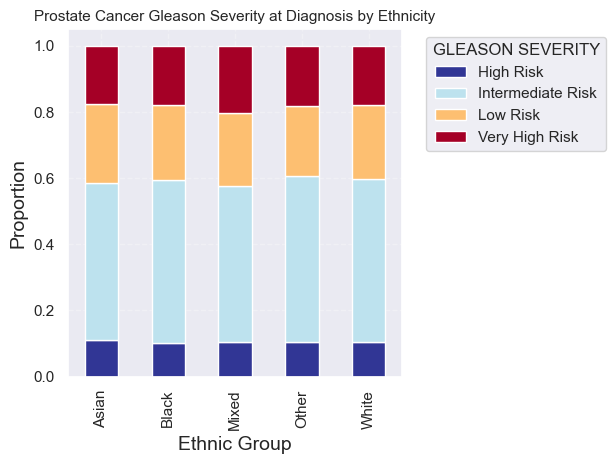

In [15]:
analysis_data = analysis_data[analysis_data['GLEASON_COMBINED'].notnull()]

conditions = [
    analysis_data['GLEASON_COMBINED'] <= 6,
    analysis_data['GLEASON_COMBINED'] ==7,
    analysis_data['GLEASON_COMBINED']==8,
    analysis_data['GLEASON_COMBINED'] >=9,
     ]


choices = ['Low Risk', 'Intermediate Risk', 'High Risk', 'Very High Risk']

analysis_data['GLEASON_SEVERITY'] = np.select(conditions, choices)

grade_by_ethnicity = pd.crosstab(analysis_data['ETHNIC_GROUP'], 
    analysis_data['GLEASON_SEVERITY'], 
    normalize='index')

plt.figure(figsize=(14, 8))
grade_by_ethnicity.plot(kind='bar', stacked=True, colormap='RdYlBu_r') 
plt.title('Prostate Cancer Gleason Severity at Diagnosis by Ethnicity', fontsize=11)
plt.xlabel('Ethnic Group', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(title='GLEASON SEVERITY', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
# plt.savefig('grade_groups_by_ethnicity.png')
plt.show()

In [16]:
# chi-square test for association between ethnicity and Gleason Severity
contingency_table = pd.crosstab(analysis_data['ETHNIC_GROUP'], analysis_data['GLEASON_SEVERITY'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
if p < 0.05:
    print("There is a significant association between ethnicity and prostate cancer Gleason Severity")
else:
    print("There is no significant association between ethnicity and prostate cancer Gleason Severity.")


Chi-square statistic: 12.24
p-value: 0.4267
Degrees of freedom: 12
There is no significant association between ethnicity and prostate cancer Gleason Severity.


/var/folders/y9/3sbrg0zd1fnd2xl6hzd2trlm0000gq/T/ipykernel_2162/1457806376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['HIGH_RISK'] = analysis_data['GLEASON_SEVERITY'].isin(['Very High RisK', 'High Risk'])


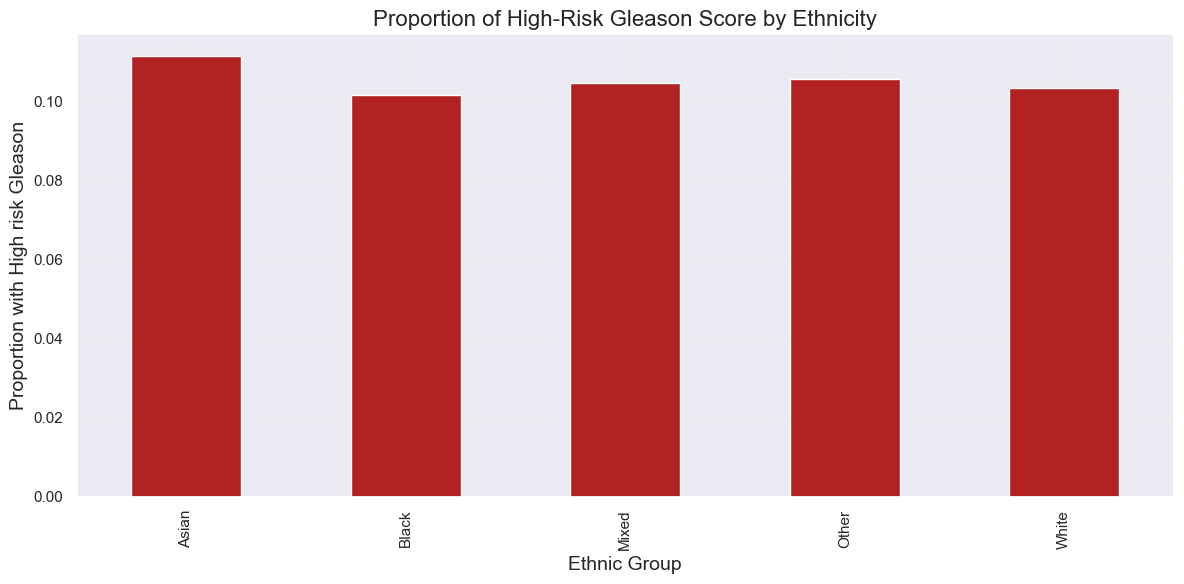

In [17]:
# proportion of high-risk gleason score by ethnic group
analysis_data['HIGH_RISK'] = analysis_data['GLEASON_SEVERITY'].isin(['Very High RisK', 'High Risk'])
high_risk_by_ethnicity = analysis_data.groupby('ETHNIC_GROUP')['HIGH_RISK'].mean()

plt.figure(figsize=(12, 6))
high_risk_by_ethnicity.plot(kind='bar', color='firebrick')
plt.title('Proportion of High-Risk Gleason Score by Ethnicity', fontsize=16)
plt.xlabel('Ethnic Group', fontsize=14)
plt.ylabel('Proportion with High risk Gleason', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
# plt.savefig('high_risk_by_ethnicity.png')
plt.show()


### 4. At what stage are patients from different ethnic groups diagnised at?

In [18]:
#Distribution of cancer stages by ethnic group
stage_distribution = pd.crosstab(
    analysis_data['ETHNIC_GROUP'],
    analysis_data['STAGE_BEST'],
    normalize='index'
)

stage_distribution


STAGE_BEST,0A,1,1A,1B,2,2A,2B,3,3A,3B,4,4A,?,A,U
ETHNIC_GROUP,,,,,,,,,,,,,,,
Asian,0.000000,0.314637,0.00000,0.000000,0.156986,0.000000,0.000000,0.220046,0.000332,0.000000,0.178228,0.000000,0.128775,0.000332,0.000664
Black,0.000000,0.301799,0.00000,0.000000,0.146878,0.000000,0.000000,0.229630,0.000000,0.000212,0.188148,0.000000,0.132487,0.000000,0.000847
Mixed,0.000000,0.318725,0.00000,0.000000,0.131474,0.000000,0.000000,0.205843,0.000000,0.000000,0.201859,0.000000,0.140770,0.000000,0.001328
Other,0.000000,0.314815,0.00000,0.000000,0.152199,0.000000,0.000000,0.230324,0.000000,0.000000,0.183449,0.000000,0.118634,0.000000,0.000579
White,0.000008,0.316910,0.00008,0.000032,0.150939,0.000032,0.000016,0.218234,0.000016,0.000008,0.178855,0.000016,0.133720,0.000000,0.001134


<Figure size 1400x700 with 0 Axes>

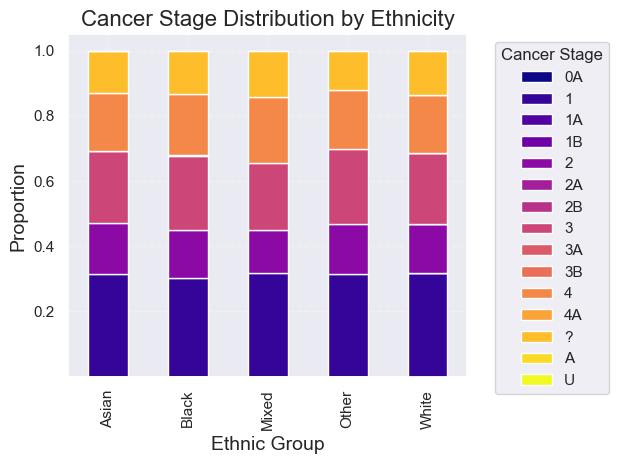

In [19]:
plt.figure(figsize=(14, 7))
stage_distribution.plot(kind='bar', stacked=True, colormap='plasma')
plt.title('Cancer Stage Distribution by Ethnicity', fontsize=16)
plt.xlabel('Ethnic Group', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(title='Cancer Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
# plt.savefig('stage_by_ethnicity.png')
plt.show()

In [20]:
stage_mapper =  {
  '0': 'Stage 0',
 '0A': 'Stage 0',
 '0IS': 'Stage 0',
 '1': 'Stage 1',
 '1A': 'Stage 1',
 '1A1': 'Stage 1',
 '1A2': 'Stage 1',
 '1A3': 'Stage 1',
 '1AE': 'Stage 1',
 '1AES': 'Stage 1',
 '1AEX': 'Stage 1',
 '1AX': 'Stage 1',
 '1B': 'Stage 1',
 '1B1': 'Stage 1',
 '1B2': 'Stage 1',
 '1BE': 'Stage 1',
 '1C': 'Stage 1',
 '1C1': 'Stage 1',
 '1C2': 'Stage 1',
 '1C3': 'Stage 1',
 '1E': 'Stage 1',
 '1EX': 'Stage 1',
 '1S': 'Stage 1',
 '1X': 'Stage 1',
 '2': 'Stage 2',
 '2A': 'Stage 2',
 '2A1': 'Stage 2',
 '2A2': 'Stage 2',
 '2AE': 'Stage 2',
 '2AEX': 'Stage 2',
 '2AS': 'Stage 2',
 '2AX': 'Stage 2',
 '2B': 'Stage 2',
 '2BEX': 'Stage 2',
 '2BX': 'Stage 2',
 '2C': 'Stage 2',
 '2E': 'Stage 2',
 '2S': 'Stage 2',
 '2X': 'Stage 2',
 '3': 'Stage 3',
 '3A': 'Stage 3',
 '3A1': 'Stage 3',
 '3A1i': 'Stage 3',
 '3A1ii': 'Stage 3',
 '3A2': 'Stage 3',
 '3AE': 'Stage 3',
 '3AES': 'Stage 3',
 '3Ai': 'Stage 3',
 '3Aii': 'Stage 3',
 '3AS': 'Stage 3',
 '3AX': 'Stage 3',
 '3B': 'Stage 3',
 '3BE': 'Stage 3',
 '3Bii': 'Stage 3',
 '3BX': 'Stage 3',
 '3C': 'Stage 3',
 '3C1': 'Stage 3',
 '3C2': 'Stage 3',
 '3D': 'Stage 3',
 '3E': 'Stage 3',
 '3ES': 'Stage 3',
 '3S': 'Stage 3',
 '4': 'Stage 4',
 '4A': 'Stage 4',
 '4AE': 'Stage 4',
 '4AES': 'Stage 4',
 '4AEXS': 'Stage 4',
 '4AS': 'Stage 4',
 '4AX': 'Stage 4',
 '4B': 'Stage 4',
 '4BE': 'Stage 4',
 '4BES': 'Stage 4',
 '4BEX': 'Stage 4',
 '4BEXS': 'Stage 4',
 '4BS': 'Stage 4',
 '4BX': 'Stage 4',
 '4BXS': 'Stage 4',
 '4C': 'Stage 4',
 '4E': 'Stage 4',
 '4ES': 'Stage 4',
 '4S': 'Stage 4',
 '4X': 'Stage 4',
 '5': 'Outdated or invalid code',
 '?': 'Insufficient information',
 'U': 'Unstageable',
 'X': 'Not staged',
 'A': 'RaiBinet stage',
 'B': 'RaiBinet stage',
 'C': 'RaiBinet stage',
 'L1': 'Unmapped value',
 'L2': 'Unmapped value',
 'M': 'Unmapped value',
 'M0': 'Unmapped value',
 'M1': 'Unmapped value',
 'M2': 'Unmapped value',
 'M3': 'Unmapped value',
 'MS': 'Unmapped value'}

In [21]:
analysis_data['Cancer Stage']=analysis_data['STAGE_BEST'].map(stage_mapper)

/var/folders/y9/3sbrg0zd1fnd2xl6hzd2trlm0000gq/T/ipykernel_2162/1408615542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['Cancer Stage']=analysis_data['STAGE_BEST'].map(stage_mapper)


In [22]:
# Distribution of cancer stages by ethnic group
stage_distribution = pd.crosstab(
    analysis_data['ETHNIC_GROUP'],
    analysis_data['Cancer Stage'],
    normalize='index'
)

stage_distribution


Cancer Stage,Insufficient information,RaiBinet stage,Stage 0,Stage 1,Stage 2,Stage 3,Stage 4,Unstageable
ETHNIC_GROUP,,,,,,,,
Asian,0.128775,0.000332,0.000000,0.314637,0.156986,0.220378,0.178228,0.000664
Black,0.132487,0.000000,0.000000,0.301799,0.146878,0.229841,0.188148,0.000847
Mixed,0.140770,0.000000,0.000000,0.318725,0.131474,0.205843,0.201859,0.001328
Other,0.118634,0.000000,0.000000,0.314815,0.152199,0.230324,0.183449,0.000579
White,0.133720,0.000000,0.000008,0.317022,0.150987,0.218258,0.178871,0.001134


<Figure size 1400x700 with 0 Axes>

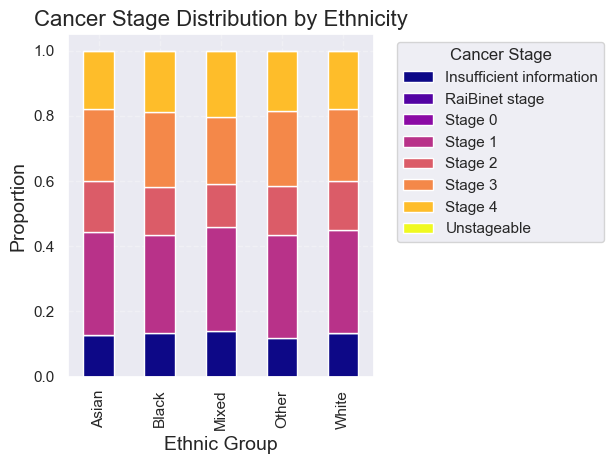

In [23]:
plt.figure(figsize=(14, 7))
stage_distribution.plot(kind='bar', stacked=True, colormap='plasma')
plt.title('Cancer Stage Distribution by Ethnicity', fontsize=16)
plt.xlabel('Ethnic Group', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(title='Cancer Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
# plt.savefig('stage_by_ethnicity.png')
plt.show()

In [24]:
# chi-square test
stage_contingency = pd.crosstab(analysis_data['ETHNIC_GROUP'], analysis_data['Cancer Stage'])
chi2_stage, p_stage, dof_stage, expected_stage = stats.chi2_contingency(stage_contingency)
print("\n\nChi-square test for Cancer Stage by Ethnicity:")
print(f"Chi-square statistic: {chi2_stage:.2f}")
print(f"p-value: {p_stage:.4f}")
if p_stage < 0.05:
    print("There is a significant association between ethnicity and cancer stage at diagnosis.")
else:
    print("There is no significant association between ethnicity and cancer stage at diagnosis.")



Chi-square test for Cancer Stage by Ethnicity:
Chi-square statistic: 64.68
p-value: 0.0001
There is a significant association between ethnicity and cancer stage at diagnosis.


<Figure size 1400x800 with 0 Axes>

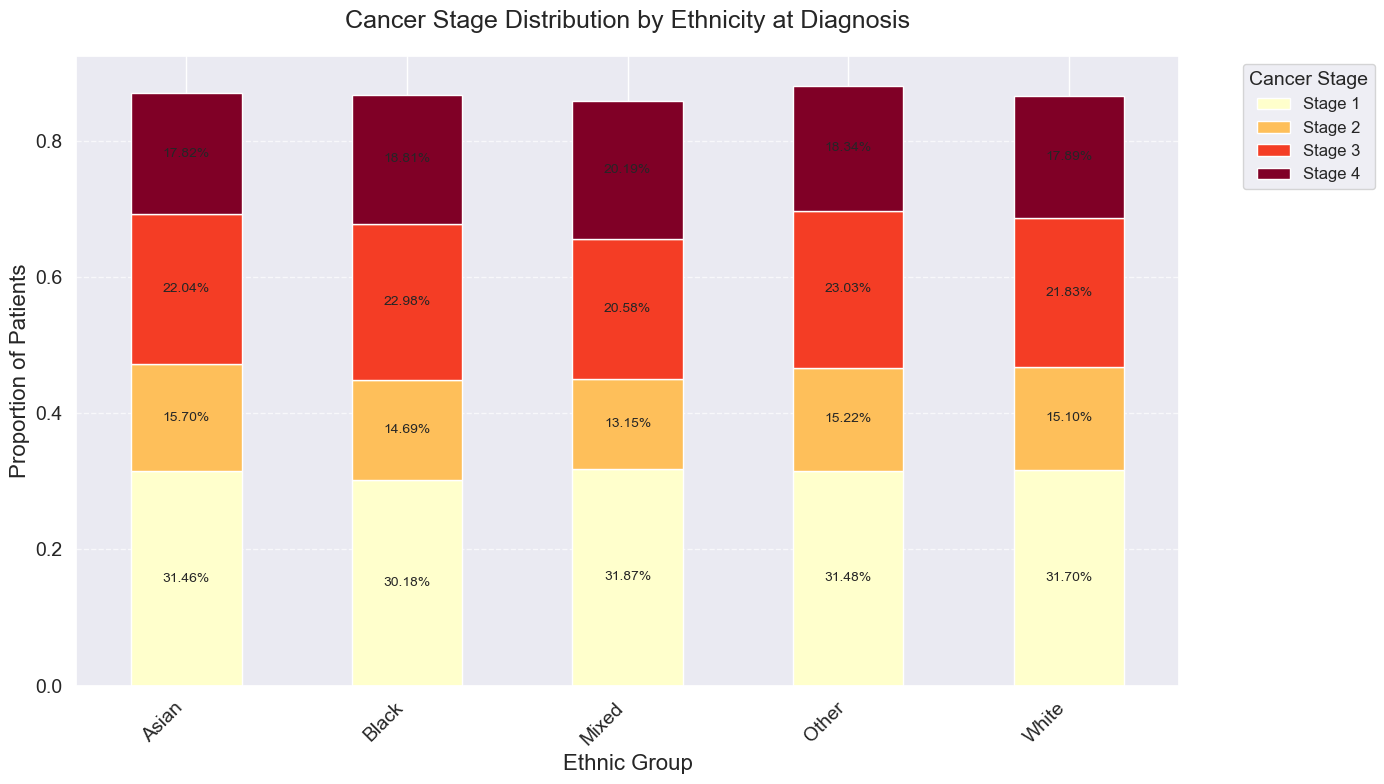

In [25]:
# advanced cancer stages
plt.figure(figsize=(14, 8))
stage_by_ethnicity = pd.crosstab(
    analysis_data['ETHNIC_GROUP'], 
    analysis_data['Cancer Stage'],
    normalize='index'
)

valid_stages = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4'] # COULDN'T FIND LITERATURE ON RaiBinet THUS EXCLUDING IT
critical_stages = [stage for stage in valid_stages if stage in stage_by_ethnicity.columns]
stage_by_ethnicity = stage_by_ethnicity[valid_stages]


ax = stage_by_ethnicity.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 8),
    colormap='YlOrRd',  )

plt.title('Cancer Stage Distribution by Ethnicity at Diagnosis', fontsize=18, pad=20)
plt.xlabel('Ethnic Group', fontsize=16)
plt.ylabel('Proportion of Patients', fontsize=16)
plt.legend(title='Cancer Stage', 
           title_fontsize=14, 
           fontsize=12, 
           bbox_to_anchor=(1.05, 1),
           loc='upper left')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, labels=['%.2f%%' % (x*100) for x in container.datavalues], 
                 label_type='center', fontsize=10)

plt.tight_layout()
# plt.savefig('detailed_stage_by_ethnicity.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
analysis_data=analysis_data[analysis_data['Cancer Stage'].isin(valid_stages)]

stage_contingency = pd.crosstab(analysis_data['ETHNIC_GROUP'], analysis_data['Cancer Stage'])

# Identify which cells are contributing to the chi-square significance
# Standardized residuals > 2 or < -2 are considered significant contributors
def standardized_residuals(observed):
    chi2, p, dof, expected = stats.chi2_contingency(observed)
    residuals = (observed - expected) / np.sqrt(expected)
    return residuals

std_residuals = standardized_residuals(stage_contingency)
std_residuals_df = pd.DataFrame(
    std_residuals,
    index=stage_contingency.index,
    columns=stage_contingency.columns
)
std_residuals_df

Cancer Stage,Stage 1,Stage 2,Stage 3,Stage 4
ETHNIC_GROUP,,,,
Asian,-0.343000,0.742878,0.044410,-0.274826
Black,-1.839034,-0.745474,1.577632,1.383898
Mixed,0.248455,-1.283691,-0.650462,1.565777
Other,-0.527904,-0.143902,0.674448,0.088244
White,0.454210,0.145521,-0.343282,-0.357606


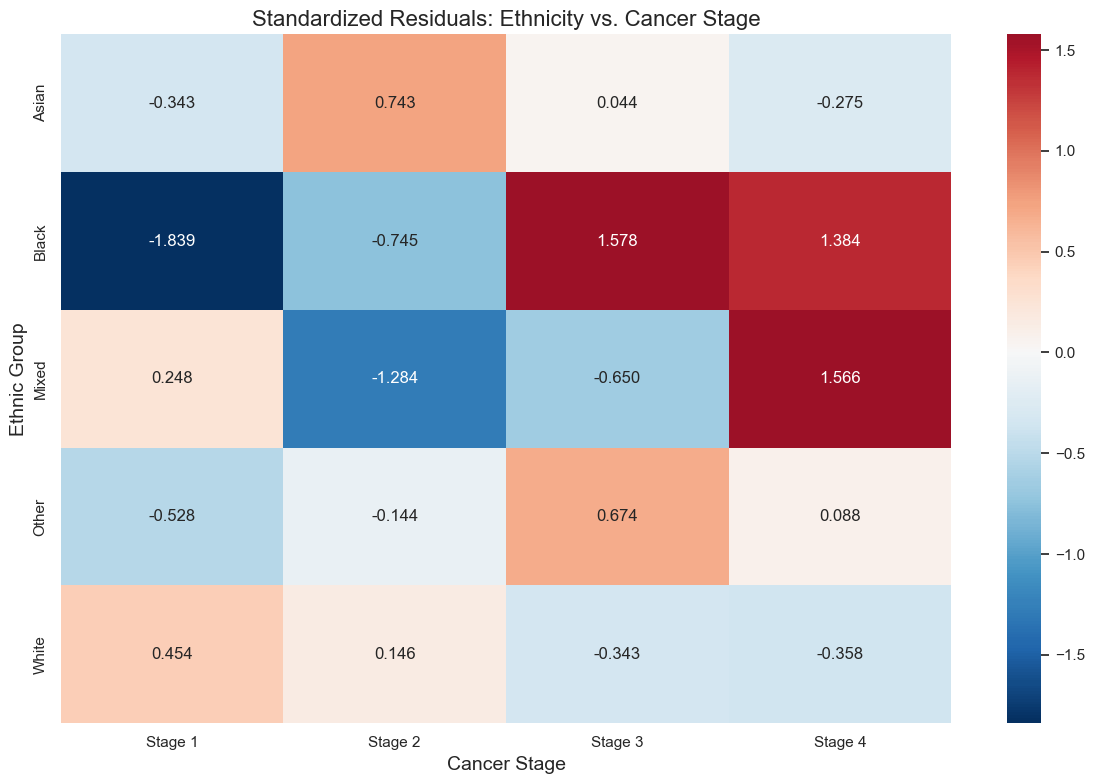

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap( std_residuals_df, annot=True, cmap='RdBu_r', center=0, fmt='.3f' )
plt.title('Standardized Residuals: Ethnicity vs. Cancer Stage', fontsize=16)
plt.xlabel('Cancer Stage', fontsize=14)
plt.ylabel('Ethnic Group', fontsize=14)
plt.tight_layout()
# plt.savefig('stage_residuals_heatmap.png', dpi=300)
plt.show()


### Conclusion
- Men of the **Mixed** race are diagnosed at an advanced stage (**Stage 4**) than men of any other race.

- More **Black** are diagnosed at an advanced stage (**Stage 4**) compared to **White** and **Asian** races.


- More men of the **Black** race are diagnosed at advanced stage 3 than any other race, followed by men of the **Other** race.


- There is no statistical significance between ethnicity and age of diagnosis.

  
- There is no statistical significance between ethnicity and gleason score at the time of diagnosis.
